In [1]:
%pylab inline
import glob
import homer
import dask.dataframe as dd
import pandas as pd
import numpy as np
import pickle
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
collection = homer.Homer(tree_filename='tests/resources/tree.json.gz')

In [2]:
collection = homer.Homer(weighted_edge_list_globstring='tests/resources/Making_Connections_Generated_Data.hdf')

In [3]:
collection.compute_clusters('working/MC_gen_clusters_*.hdf', min_threshold=1)

In [4]:
collection.clusters.head()

,Set,k,threshold,Date
0,soul gold covet,3.0,4,1
1,care markd pray fewer peace share greater coun...,3.0,4,1
2,peace live one wish things wear,4.0,4,1
3,gold one offending,3.0,3,1
4,coz pray one dwell gods alive care soul markd ...,3.0,3,1


In [3]:
collection.compute_relations('working/MC_gen_relations_*.hdf')

AttributeError: 'Homer' object has no attribute 'clusters'

In [6]:
collection.compute_tree()

In [8]:
node = collection.tree.find('4')
node.k_children

[5,
 6,
 7,
 8,
 9,
 coz,
 gold,
 jove,
 greater,
 country,
 thee,
 gods,
 garments,
 loss,
 covetous,
 alive]

In [9]:
node.compute_size()

(255.0, 59.5)

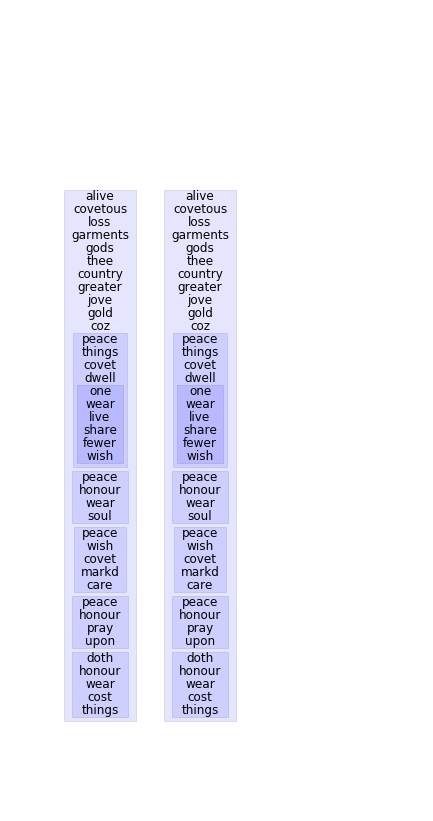

In [11]:
fig = plt.figure(figsize=(7,14))
ax = plt.gca()
node.draw(ax, 100, 100)
node.draw(ax, 200, 100)

In [7]:
node.child_bottoms

In [33]:
collection.clusters.reset_index(drop=True).compute()

,Set,k,threshold,Date
0,live one wish peace wear,3,6,1
1,live wish wear one fewer share peace,3,13,3
2,live wish wear one fewer share peace,3,12,3
3,live wish wear one fewer share peace,3,11,3
4,live wish wear one fewer share peace,3,10,3
5,live wish wear one fewer share peace,3,5,1
6,live yearns desires dwell offending pray peace...,3,1,2
7,care markd wish covet cost,5,4,2
8,live yearns desires dwell offending gods pray ...,3,1,1
9,care markd wish covet cost,5,3,2


In [31]:
df = collection.clusters.compute()

In [32]:
df

,Set,k,threshold,Date
ID,,,,
-9056716754200133287,live one wish peace wear,3,6,1
-8968590625581934390,live wish wear one fewer share peace,3,13,3
-8968589172093433065,live wish wear one fewer share peace,3,12,3
-8968587718594951140,live wish wear one fewer share peace,3,11,3
-8968586265106449815,live wish wear one fewer share peace,3,10,3
-8968578997651467440,live wish wear one fewer share peace,3,5,1
-8851245618890672828,live yearns desires dwell offending pray peace...,3,1,2
-8782763083573580906,care markd wish covet cost,5,4,2
-8665238872588369456,live yearns desires dwell offending gods pray ...,3,1,1


In [11]:
a = collection.clusters[collection.clusters['k']==7].compute()
a

,Set,k,threshold,Date
ID,,,,
-6164480443017821638,upon fewer live honour wear share peace,7,1,1


In [14]:
child = root.find(str(a.index[0]))
child.k_children

[share, upon, peace, fewer, live, honour, wear]

In [17]:
b = collection.clusters[collection.clusters['k']==6][collection.clusters['Date']==1].compute()
b

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py:249: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*args2)


,Set,k,threshold,Date
ID,,,,
-8448021559611643807,dwell upon covet wish markd things fewer live ...,6,1,1
-6704097345979941056,care markd wish live share peace,6,1,1
-1292011934155600227,dwell markd covet wish garments one,6,1,1
-51002126403807112,care doth markd wish things live honour gods,6,1,1
2617171587878002598,upon live honour wear share peace,6,2,1
3394883846396084971,care dwell markd covet wish share,6,1,1


In [27]:
b = collection.clusters[collection.clusters['k']==5][collection.clusters['Date']==1].compute()
b

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py:249: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*args2)


,Set,k,threshold,Date
ID,,,,
-6184392761650886715,dwell markd garments covet wish one,5,2,1
-3101355562922971180,wish fewer live wear one share,5,3,1
360431357983146192,dwell upon markd garments doth jove wear engla...,5,1,1
7925733623849426782,doth upon wish things fewer live honour wear o...,5,2,1


In [28]:
parent = root.find('360431357983146192')
parent.k_children

[-8448021559611643807,
 -6704097345979941056,
 -1292011934155600227,
 -51002126403807112,
 3394883846396084971,
 jove,
 coz,
 soul,
 thee,
 england,
 gold,
 country,
 alive,
 faith,
 covetous,
 greater,
 yearns]

In [29]:
for n in homer.tree.walk_k_ancestry(parent):
    print(n, n.k_children)

share []
upon []
peace []
fewer []
live []
honour []
wear []
-6164480443017821638 [share, upon, peace, fewer, live, honour, wear]
dwell []
markd []
covet []
wish []
things []
pray []
one []
cost []
outward []
-8448021559611643807 [-6164480443017821638, dwell, markd, covet, wish, things, pray, one, cost, outward]
care []
share []
markd []
wish []
live []
peace []
-6704097345979941056 [care, share, markd, wish, live, peace]
dwell []
markd []
garments []
covet []
wish []
one []
-1292011934155600227 [dwell, markd, garments, covet, wish, one]
care []
doth []
markd []
wish []
things []
live []
honour []
gods []
-51002126403807112 [care, doth, markd, wish, things, live, honour, gods]
care []
dwell []
markd []
covet []
wish []
share []
3394883846396084971 [care, dwell, markd, covet, wish, share]
jove []
coz []
soul []
thee []
england []
gold []
country []
alive []
faith []
covetous []
greater []
yearns []
360431357983146192 [-8448021559611643807, -6704097345979941056, -1292011934155600227, -51

In [35]:
list(zip((1,2), (11, 22), (111, 222)))

[(1, 11, 111), (2, 22, 222)]

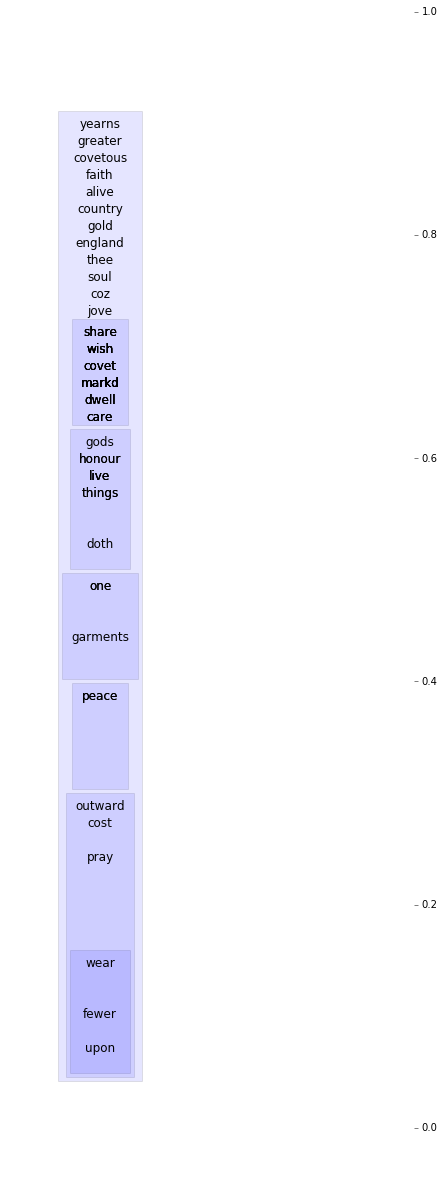

In [33]:
fig = plt.figure(figsize=(7,20))
ax = plt.gca()
ax_test = ax.twinx()
parent.layout(ax_test)
parent.set_bottom(100)
parent.set_center(100)
parent.draw(ax)

In [22]:
parent.draw()

TypeError: draw() missing 1 required positional argument: 'ax'

In [ ]:
a.k_children[2] is b.k_children[5]

In [31]:
collection.clusters[collection.clusters['k']==7].compute()

,Set,k,threshold,Date
ID,,,,
-2943944007688239924,peace share live upon honour wear fewer,7,1,1


In [37]:
collection.clusters[(collection.clusters['k']==6)].compute()

,Set,k,threshold,Date
ID,,,,
-8596872330028569940,peace share live wish fewer honour wear,6,2,3
-8596875237009315315,peace share live wish fewer honour wear,6,4,4
-8596870876536325890,peace share live wish fewer honour wear,6,3,4
-5853114226745766784,peace share live wish wear fewer honour upon,6,1,3
-4702866424366699832,outward peace share live pray markd wish dwell...,6,1,1
-2948239378724855240,care share markd wish dwell covet,6,1,1
-3346707278463544760,live one fewer honour things wear cost,6,1,3
-3172245855120495490,live one fewer honour things wear,6,2,4
-2861959016774172950,peace share live wish wear fewer honour,6,2,4
